In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## Часть 1

Опишем функцию потерь согласно формуле ниже:

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  X = np.array(X)
  y = np.array(y)
  w = np.array(w)
  N = X.shape[0]
  L = 0
  for i in range(N):
    L += np.log(1 + np.exp(-y[i] * (w @ X[i] + w0)))
  L /= N
  L += gamma * np.sum(np.abs(w)) + beta * np.sum(w**2)
  return L

##Часть 2

Опишем функцию, возвращающую градиенты весов по формулам:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

In [2]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
  X = np.array(X)
  y = np.array(y)
  w = np.array(w)
  N, n = X.shape
  gradient_w = np.zeros(n)
  gradient_w0 = 0
  for i in range(N):
    sigmoid = 1 / (1 + np.exp(y[i] * (X[i] @ w + w0)))
    gradient_w += X[i] * y[i] * sigmoid
    gradient_w0 += y[i] * sigmoid
  gradient_w /= -N
  gradient_w0 /= -N
  gradient_w += gamma * np.sign(w) + 2 * beta * w
  return gradient_w.tolist(), gradient_w0

Проверим работоспособность кода:

In [3]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

##Часть 3

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

Класс реализует логистическую реггрессию методом стохастического градиентного спуска. После обучения на выборке получаем веса, с помощью которым осуществляем предсказания. Центральной формулой тут является сигмоидная функция, она дает возможность преобразования признаков в вероятностность. Эти вероятности используются также для получения предсказанных значений.

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        pass


    def fit(self, X, y):
      np.random.seed(42)
      X = np.array(X)
      y = np.array(y)
      n_samples, n_features = X.shape
      self.weights = np.random.randn(n_features)
      self.bias = 0
      last_loss = np.inf
      for i in range(self.max_iter):
        current_loss = loss(X, y, self.weights, self.bias, self.gamma, self.beta)
        if abs(last_loss - current_loss) < self.tolerance:
          break
        self.loss_history.append(current_loss)
        last_loss = current_loss
        gradient_w, gradient_w0 = get_grad(X, y, self.weights, self.bias, self.gamma, self.beta)
        self.weights -= self.lr * np.array(gradient_w)
        self.bias -= self.lr * gradient_w0


    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        probabilities = self.predict_proba(X)
        return np.where(probabilities >= 0.5, 1, 0)


    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        linear_model = np.dot(X, self.weights) + self.bias
        return 1 / (1 + np.exp(-linear_model))

In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

##Часть 4

Функция применяет модель для предсказания и формирует границу, после чего наносит точки с данными.

In [ ]:
def plot_decision_boundary(model, X, y):
  fig, ax = plt.subplots()
  x_min, x_max = X[:, 0].min(), X[:, 0].max()
  y_min, y_max = X[:, 1].min(), X[:, 1].max()
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
  z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  z = z.reshape(xx.shape)
  ax.contourf(xx, yy, z, alpha=0.5)
  ax.scatter(X[:,0], X[:,1], c=y)
  plt.show()

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)

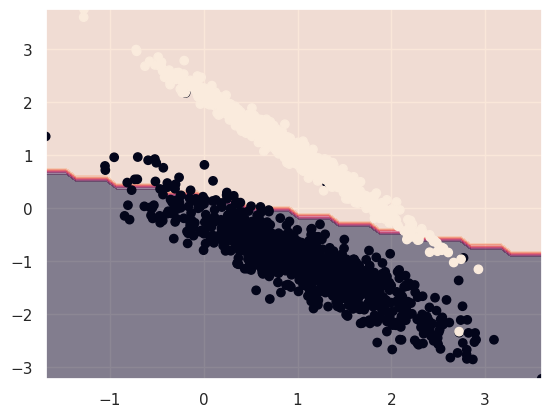

In [ ]:
plot_decision_boundary(model, X, y)

##Часть 5

Добавим в класс Logit хранение истории потерь, а в данной функции отрисуем функцию, описывающую потери при повышении числа итераций.

In [ ]:
def plot_loss_history(model):
    plt.plot(model.loss_history, label="Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

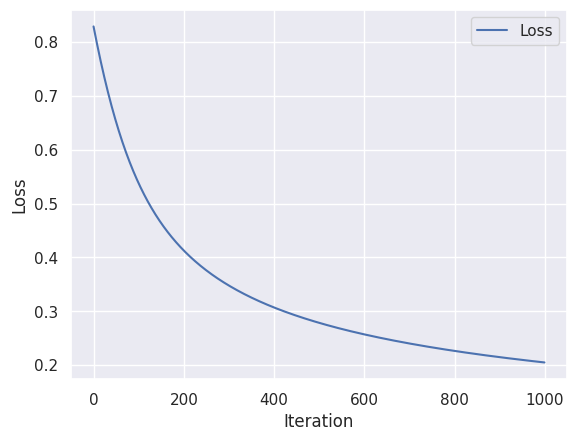

In [ ]:
plot_loss_history(model)

##Часть 6

Функция metrics принимает итоговые и предсказанные значения и выводит точность предсказания с разными метриками. Далее проверяем точность предсказаний SVC (опорные векторы) библиотеки sklearn с разными значениями kernel и C.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split


def metrics(test, predicted, proba):
  print(f"Accuracy: {accuracy_score(test, predicted):.2f}\n"
        f"Precision: {precision_score(test, predicted):.2f}\n"
        f"Recall: {recall_score(test, predicted):.2f}\n"
        f"F1-Score: {f1_score(test, predicted):.2f}\n"
        f"AUC-ROC: {roc_auc_score(test, proba)}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100, 1000]

for kernel in kernel_values:
  for C in C_values:
    model = SVC(C=C, kernel=kernel, probability=True, random_state=42)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"Kernel: {kernel}, C: {C}:")
    metrics(y_test, y_predicted, y_proba)
    print('\n')

Kernel: linear, C: 0.1:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.9998146088246199


Kernel: linear, C: 1:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.9993511308861698


Kernel: linear, C: 10:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.9987949573600297


Kernel: linear, C: 100:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.9987949573600297


Kernel: linear, C: 1000:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.9987949573600297


Kernel: poly, C: 0.1:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.996261277963169


Kernel: poly, C: 1:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.9976826103077494


Kernel: poly, C: 10:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.9985477691261896


Kernel: poly, C: 100:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 0.9986095661846496

##Часть 7

Приспособим KNN из прошлого дз для задач классификации. В функции предсказания вероятностей находим уникальные классы и частоту их появления у ближайших соседей и, в зависимости от результата, получаем вероятности. По индексу максимальной вероятности получаем наиболее вероятный класс.

In [ ]:
from collections import Counter


class KNNClassifier:
  def __init__(self, n_neighbors=5, metric='euclidean'):
    self.n_neighbors = n_neighbors
    self.metric = metric

  def fit(self, X, y):
    self.X_train = np.array(X)
    self.y_train = np.array(y)

  def calculate_distance(self, x1, x2):
    if self.metric == 'euclidean':
      return np.sqrt(np.sum((x1 - x2) ** 2))
    elif self.metric == 'manhattan':
      return np.sum(np.abs(x1 - x2))
    else:
      raise ValueError("Введена недоступная метрика.")

  def predict_proba(self, X):
    X = np.array(X)
    probas = []
    classes = np.unique(y)
    for x in X:
      distances = [self.calculate_distance(x, x_train) for x_train in self.X_train]
      k_nearest = np.argsort(distances)[:self.n_neighbors]
      y_of_k_nearest = [self.y_train[i] for i in k_nearest]
      class_counts = Counter(y_of_k_nearest)
      probabilities = np.array([class_counts.get(cls, 0) / self.n_neighbors for cls in classes])
      probas.append(probabilities)
    return np.array(probas)

  def predict(self, X):
    probas = self.predict_proba(X)
    class_indices = np.argmax(probas, axis=1)
    return self.classes_[class_indices]

##Часть 8

In [ ]:
df = pd.read_csv("train.csv")

Поделим импортированную выборку:

In [ ]:
train_df = df.iloc[:50000]
test_df = df.iloc[50000:]

##Часть 9

Первый столбец является индексом, второй категорией, остальные 784 - пиксели картинок из Fashion Mnist. Выведем с помощью plt по экземпляру.

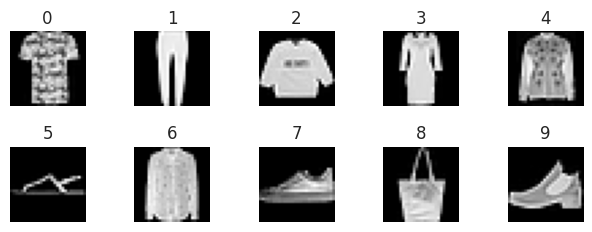

In [ ]:
y = df.iloc[:, 1].values
X = df.iloc[:, 2:].values
unique_classes = np.unique(y)
for i, class_label in enumerate(unique_classes):
  idx = np.where(y == class_label)[0][0]
  img = X[idx].reshape(28, 28)
  plt.subplot(4, 5, i + 1)
  plt.imshow(img, cmap='gray')
  plt.title(class_label)
  plt.axis('off')
plt.tight_layout()
plt.show()

##Часть 10

Сначала отнормируем данные с помощью StandardScaler. Как видим, все данные отцентрированы:

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X)
df_standard = pd.DataFrame(X_standard, columns=df.columns[2:])
df_standard = pd.concat([pd.DataFrame(y, columns=df.columns[:1]), df_standard], axis=1)
df_standard

,Id,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,Pixel008,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,2,-0.009505,-0.022693,-0.028907,-0.041557,-0.057575,-0.070503,-0.098084,-0.155981,-0.238546,...,-0.601712,-0.476945,-0.395154,-0.406441,-0.440185,-0.396719,-0.287717,-0.158258,-0.091432,-0.033046
1,9,-0.009505,-0.022693,-0.028907,-0.041557,-0.057575,-0.070503,-0.098084,-0.155981,-0.238546,...,-0.601712,-0.476945,-0.395154,-0.406441,-0.440185,-0.396719,-0.287717,-0.158258,-0.091432,-0.033046
2,6,-0.009505,-0.022693,-0.028907,-0.041557,-0.057575,-0.070503,-0.098084,0.198798,-0.238546,...,-0.601712,-0.476945,-0.395154,0.275910,0.389449,-0.396719,-0.287717,-0.158258,-0.091432,-0.033046
3,0,-0.009505,-0.022693,-0.028907,0.366132,0.406799,-0.070503,-0.098084,-0.155981,-0.238546,...,-0.549579,-0.476945,-0.395154,-0.406441,-0.440185,-0.374570,-0.287717,-0.158258,-0.091432,-0.033046
4,3,-0.009505,-0.022693,-0.028907,-0.041557,-0.057575,-0.070503,-0.098084,-0.155981,-0.238546,...,-0.601712,-0.476945,-0.395154,-0.406441,-0.440185,-0.396719,-0.287717,-0.158258,-0.091432,-0.033046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,-0.009505,-0.022693,-0.028907,-0.041557,-0.057575,-0.070503,-0.098084,-0.155981,-0.238546,...,-0.601712,-0.476945,-0.395154,-0.406441,-0.440185,-0.396719,-0.287717,-0.158258,-0.091432,-0.033046
59996,1,-0.009505,-0.022693,-0.028907,-0.041557,-0.057575,-0.070503,-0.098084,-0.155981,-0.238546,...,0.666865,-0.476945,-0.395154,-0.406441,-0.440185,-0.396719,-0.287717,-0.158258,-0.091432,-0.033046
59997,8,-0.009505,-0.022693,-0.028907,-0.041557,-0.057575,-0.070503,-0.098084,-0.155981,-0.238546,...,2.178732,2.839056,3.487716,2.664137,1.373435,-0.396719,-0.287717,-0.158258,-0.091432,-0.033046
59998,8,-0.009505,-0.022693,-0.028907,-0.041557,-0.057575,-0.070503,-0.098084,-0.155981,-0.238546,...,-0.601712,-0.476945,-0.395154,-0.406441,-0.440185,-0.396719,-0.287717,-0.158258,-0.091432,-0.033046


Теперь MinMaxSlacer. Данные приобрели значения от [0,1]

In [ ]:
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)
df_minmax = pd.DataFrame(X_minmax, columns=df.columns[2:])
df_minmax = pd.concat([pd.DataFrame(y, columns=df.columns[:1]), df_minmax], axis=1)
df_minmax

,Id,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,Pixel008,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,...,0.000000,0.000000,0.000000,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.006098,0.008811,0.0,0.0,0.000000,0.0,...,0.011765,0.000000,0.000000,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
59996,1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.286275,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
59997,8,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.627451,0.635294,0.639216,0.529412,0.368627,0.000000,0.0,0.0,0.0,0.0
59998,8,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


Для KNN основным гиперпараметром будет количество соседей, напрямую влияющий на качество предсказания. Также добавим функцию весов, метрику измерения расстояния и алгоритм вычисления соседей (они не будут глобально влиять и в среднем будут выводится их значения по умолчанию).

Для логистической регрессии, помимо C, попробуем изменять количество максимальных итераций.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

knn_params = {
    'n_neighbors': [3,4,5,6,7,8,9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
logistic_params = {
    'max_iter': [100, 200, 500, 1000],
    'C': [0.01, 0.1, 1, 10, 100]
}
knn = KNeighborsClassifier()
logistic = LogisticRegression()
knn_grid_search = GridSearchCV(knn, knn_params, scoring='accuracy', cv=5)
logistic_grid_search = GridSearchCV(logistic, logistic_params, scoring='accuracy', cv=5)
knn_grid_search.fit(X_train, y_train)
logistic_grid_search.fit(X_train, y_train)
print(knn_grid_search.best_params_)
print(logistic_grid_search.best_params_)

{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
{'C': 0.1, 'max_iter': 100}


##Бонусы

###Задача 1

Предоставленная ситуация влияет сразу на несколько факторов:

1. Неизменяемость весов. В признаках нет различий,градиенты потерь схожи,  из-за этого не будут изменяться веса для различия классов.
2. Поскольку модель не может различить классы по признакам, она будет делать предсказания случайно или же одинаковые предсказания, что приблизит точность к 0.5.

Продемонстрируем с помощью кода:

In [ ]:
n_samples = 10000
n_features = 2
X = np.ones((n_samples, n_features))
y = np.array([0] * 5000 + [1] * 5000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
y_pred

Accuracy: 0.49


array([1, 1, 1, ..., 1, 1, 1])

Действительно, все предсказания равны 1, точность близка к 0.5.